* TODO :
        * Compare the plotted graphs for the interpolated vs daily vs original datasets
        * Adapt the function for plotting the original dataset
        * Compare the count of missing values in untinterpolated and interpolated by using .isna().sum() for both
        * Handle the resampling size for week and month so they use either interpolated or not depending on what I think looks better from the plots (do we even need to do them?)
* after doing teh above 2 things should be finished with EDA and preprocessing can move on to feature engineering and data preparation for the RNN algorithms

# EDA of the data
* Performing an EDA of the data to discover preliminary patterns and problems which we will use in our preprocessing of the data

# Importing required libraries

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, MinMaxScaler
from datetime import datetime
from tqdm.notebook import tqdm #lets us display pretty progress bars for loops
import seaborn as sns
from datetime import timedelta
from datetime import date
from dateutil.relativedelta import relativedelta
import random #used for randomly selecting which plots to display (as there are a lot)

# Setting up display options for pandas

In [158]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Loading the data
* Try to load from pickle file as it is quicker to access
* If this fails, load the original CSV and save it to a pickle file
* <b>No point in doing anything with weather data as we only have 1 years worth of values so it is impossible to leverage with our chosen RNN/CNN based models to predict the next years worth of energy readings</b>
    * <b>Unless we leveraged them to produce multivariate predictions and also predicting the weathers values in order to use those as input for subsequent days: but this will likely result in worse performing energy predictions</b>
* Hence we are only looking into addInfo and consumption

In [159]:
#try to load pickle file as it is quicker
try:
    print("Loading consumption via pickle")
    df_energy = pd.read_pickle("../Data/Original_Data/consumption.pkl")
# if the file was not found then load the csv then save it to pickle for future loads
except:
    print("Loading consumption via csv")
    df_energy = pd.read_csv("../Data/Original_Data/consumption.csv")
    df_energy.to_pickle("../Data/Original_Data/consumption.pkl")

    #try to load pickle file as it is quicker
try:
    print("Loading addInfo via pickle")
    df_info = pd.read_pickle("../Data/Original_Data/addInfo.pkl")
# if the file was not found then load the csv then save it to pickle for future loads
except:
    print("Loading addInfo via csv")
    df_info = pd.read_csv("../Data/Original_Data/addInfo.csv")
    df_info.to_pickle("../Data/Original_Data/addInfo.pkl")

Loading consumption via pickle
Loading addInfo via pickle


# Inspecting df_energy and df_info

In [160]:
# inspecting the values of the dataframe
df_energy

,meter_id,2017-01-01 00:00:00,2017-01-01 00:30:00,2017-01-01 01:00:00,2017-01-01 01:30:00,2017-01-01 02:00:00,2017-01-01 02:30:00,2017-01-01 03:00:00,2017-01-01 03:30:00,2017-01-01 04:00:00,2017-01-01 04:30:00,2017-01-01 05:00:00,2017-01-01 05:30:00,2017-01-01 06:00:00,2017-01-01 06:30:00,2017-01-01 07:00:00,2017-01-01 07:30:00,2017-01-01 08:00:00,2017-01-01 08:30:00,2017-01-01 09:00:00,2017-01-01 09:30:00,2017-01-01 10:00:00,2017-01-01 10:30:00,2017-01-01 11:00:00,2017-01-01 11:30:00,2017-01-01 12:00:00,2017-01-01 12:30:00,2017-01-01 13:00:00,2017-01-01 13:30:00,2017-01-01 14:00:00,2017-01-01 14:30:00,2017-01-01 15:00:00,2017-01-01 15:30:00,2017-01-01 16:00:00,2017-01-01 16:30:00,2017-01-01 17:00:00,2017-01-01 17:30:00,2017-01-01 18:00:00,2017-01-01 18:30:00,2017-01-01 19:00:00,2017-01-01 19:30:00,2017-01-01 20:00:00,2017-01-01 20:30:00,2017-01-01 21:00:00,2017-01-01 21:30:00,2017-01-01 22:00:00,2017-01-01 22:30:00,2017-01-01 23:00:00,2017-01-01 23:30:00,2017-01-02 00:00:00,2017-01-02 00:30:00,2017-01-02 01:00:00,2017-01-02 01:30:00,2017-01-02 02:00:00,2017-01-02 02:30:00,2017-01-02 03:00:00,2017-01-02 03:30:00,2017-01-02 04:00:00,2017-01-02 04:30:00,2017-01-02 05:00:00,2017-01-02 05:30:00,2017-01-02 06:00:00,2017-01-02 06:30:00,2017-01-02 07:00:00,2017-01-02 07:30:00,2017-01-02 08:00:00,2017-01-02 08:30:00,2017-01-02 09:00:00,2017-01-02 09:30:00,2017-01-02 10:00:00,2017-01-02 10:30:00,2017-01-02 11:00:00,2017-01-02 11:30:00,2017-01-02 12:00:00,2017-01-02 12:30:00,2017-01-02 13:00:00,2017-01-02 13:30:00,2017-01-02 14:00:00,2017-01-02 14:30:00,2017-01-02 15:00:00,2017-01-02 15:30:00,2017-01-02 16:00:00,2017-01-02 16:30:00,2017-01-02 17:00:00,2017-01-02 17:30:00,2017-01-02 18:00:00,2017-01-02 18:30:00,2017-01-02 19:00:00,2017-01-02 19:30:00,2017-01-02 20:00:00,2017-01-02 20:30:00,2017-01-02 21:00:00,2017-01-02 21:30:00,2017-01-02 22:00:00,2017-01-02 22:30:00,2017-01-02 23:00:00,2017-01-02 23:30:00,2017-01-03 00:00:00,2017-01-03 00:30:00,2017-01-03 01:00:00,2017-01-03 01:30:00,2017-01-03 02:00:00,2017-01-03 02:30:00,2017-01-03 03:00:00,2017-01-03 03:30:00,2017-01-03 04:00:00,2017-01-03 04:30:00,2017-01-03 05:00:00,2017-01-03 05:30:00,2017-01-03 06:00:00,2017-01-03 06:30:00,2017-01-03 07:00:00,2017-01-03 07:30:00,2017-01-03 08:00:00,2017-01-03 08:30:00,2017-01-03 09:00:00,2017-01-03 09:30:00,2017-01-03 10:00:00,2017-01-03 10:30:00,2017-01-03 11:00:00,2017-01-03 11:30:00,2017-01-03 12:00:00,2017-01-03 12:30:00,2017-01-03 13:00:00,2017-01-03 13:30:00,2017-01-03 14:00:00,2017-01-03 14:30:00,2017-01-03 15:00:00,2017-01-03 15:30:00,2017-01-03 16:00:00,2017-01-03 16:30:00,2017-01-03 17:00:00,2017-01-03 17:30:00,2017-01-03 18:00:00,2017-01-03 18:30:00,2017-01-03 19:00:00,2017-01-03 19:30:00,2017-01-03 20:00:00,2017-01-03 20:30:00,2017-01-03 21:00:00,2017-01-03 21:30:00,2017-01-03 22:00:00,2017-01-03 22:30:00,2017-01-03 23:00:00,2017-01-03 23:30:00,2017-01-04 00:00:00,2017-01-04 00:30:00,2017-01-04 01:00:00,2017-01-04 01:30:00,2017-01-04 02:00:00,2017-01-04 02:30:00,2017-01-04 03:00:00,2017-01-04 03:30:00,2017-01-04 04:00:00,2017-01-04 04:30:00,2017-01-04 05:00:00,2017-01-04 05:30:00,2017-01-04 06:00:00,2017-01-04 06:30:00,2017-01-04 07:00:00,2017-01-04 07:30:00,2017-01-04 08:00:00,2017-01-04 08:30:00,2017-01-04 09:00:00,2017-01-04 09:30:00,2017-01-04 10:00:00,2017-01-04 10:30:00,2017-01-04 11:00:00,2017-01-04 11:30:00,2017-01-04 12:00:00,2017-01-04 12:30:00,2017-01-04 13:00:00,2017-01-04 13:30:00,2017-01-04 14:00:00,2017-01-04 14:30:00,2017-01-04 15:00:00,2017-01-04 15:30:00,2017-01-04 16:00:00,2017-01-04 16:30:00,2017-01-04 17:00:00,2017-01-04 17:30:00,2017-01-04 18:00:00,2017-01-04 18:30:00,2017-01-04 19:00:00,2017-01-04 19:30:00,2017-01-04 20:00:00,2017-01-04 20:30:00,2017-01-04 21:00:00,2017-01-04 21:30:00,2017-01-04 22:00:00,2017-01-04 22:30:00,2017-01-04 23:00:00,2017-01-04 23:30:00,2017-01-05 00:00:00,2017-01-05 00:30:00,2017-01-05 01:00:00,2017-01-05 01:30:00,2017-01-05 02:00:00,2017-01-05 02:30:00,2017-01-05 03:00:00,2017-01-05

In [161]:
# inspecting the shape of the dataframe
df_energy.shape

(3248, 17521)

In [162]:
# inspecting the values of the dataframe
df_info

,meter_id,dwelling_type,num_occupants,num_bedrooms,heating_fuel,hot_water_fuel,boiler_age,loft_insulation,wall_insulation,heating_temperature,efficient_lighting_percentage,dishwasher,freezer,fridge_freezer,refrigerator,tumble_dryer,washing_machine,game_console,laptop,pc,router,set_top_box,tablet,tv
0,0x02b7418b821b2edeeb2baa23ba1580566b4b0e43,semi_detached_house,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0xaf32b2b497e9eb9c3f3de907aedc6a7914a11f41,terraced_house,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0xdd45ab28a7a40eadc04607d6da42e5ad923b1339,semi_detached_house,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0x2b538a5ebfc3780aef25227267063cb6410d943b,detached_house,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0xee032ed498c9e99a4c65e0f39896fb30e513c6b7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,0xb9c600842cb2d195d461d675f2758ddbf5bb45bb,terraced_house,2.0,2.0,gas,gas,old,y,n,18_to_20,75_to_100,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,1.0,0.0,1.0
2139,0x429e76a41f3141d9e62c4975e6b5df303cb45e64,bungalow,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2140,0x65fbd9ba598e703d742a32058ea2b323fe4c1fca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2141,0x101f2dc409b3b95d2bb08ebe5d282f54317e3f8c,bungalow,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
# inspecting the shape of the dataframe
df_info.shape

(2143, 24)

#### Conclusions to be drawn

* Can see that df_info only has entries for 2140 of the 3248 possible rows
* Must add the missing rows filled with NaN
    * Done in the EDA on AddInfo section where we simply join based on meter_id

# EDA on consumption

In [164]:
# how many missing values?
print(df_energy.isnull().sum().sum())

29378388


##### Conclusions:
* Large number of missing values hence we must find a way to deal with that
    * Will experiment with:
        1. Imputing the missing values linearly
        2. Dropping the missing values entirely and only using values we do have
        3. just treating missing values as 0
        
## Function for resampling into different time periods (will need this a lot)


* df_energy = the dataframe we are wanting to reschedule up
* file_name = name of file we will save it as
* resample_size = "D" or "M" or "W" corresponding to what period we are resampling into
* acceptNan = true if we want to include nans in our sums, false if we want to set entire column to nan if it includes a nan

In [165]:
def resample_to_different_time(df_energy, file_name, resample_size, acceptNaN):
    meter_id=df_energy["meter_id"]
    df_energy_new = pd.DataFrame(columns=["meter_id"])
    df_energy_new["meter_id"] = meter_id

    #for date of the resample size in the range of dates
    for new_sample in tqdm(pd.date_range(datetime(2017, 1, 1), datetime(2017, 12, 31), freq = resample_size),position=0):
        
        #get this columns name as a string
        if(resample_size=="M"):
            columnName = str(new_sample.date())[:7]
        elif(resample_size=="D" or resample_size=="W"):
            columnName = str(new_sample.date())
        else:
            return

        #if this isn't a week we can simply take those that start with the new columnName
        if(resample_size!="W"):
            #get all columns that relate to this new sample
            columns = [i for i in df_energy.columns.values[1:] if i.startswith(columnName)]
            
        #if it is a week be a bit more fancy find the days in the range of this week
        else:
            columns = []
            #for each day in range of this week
            for weeks_day in pd.date_range(new_sample, new_sample+timedelta(days=6), freq="D"):
                #get todays name as a string
                dayName = str(weeks_day.date())
                #get all columns that relate to this day
                dayColumns = [i for i in df_energy.columns.values[1:] if i.startswith(dayName)]
                #add it to the week total
                columns = columns+dayColumns
                
        #if we do not want to accept nans in our new columns
        if(acceptNaN==False):
            #get series of boolean values saying if each row of these columns contain a null
            series_bool_contains_nulls = df_energy[columns].apply(lambda row: row.isnull().values.any(), axis=1)
            
            #for each rows boolean contains nulls truth value
            for row_id in tqdm(range(len(series_bool_contains_nulls)), position=1, leave=False):
                #this rows corresponding truth value for whether or not it contains nulls
                bool_contains_null=series_bool_contains_nulls[row_id]
                
                #if this row contains nulls set it's corresponding cell in the new column to null
                if(bool_contains_null==True):
                    print(columnName,str(meter_id[row_id]),"(",str(row_id),") contains a null, setting this column to null")
                    df_energy_new.at[row_id,columnName]=np.nan
                #else this row doesn't contain nulls set it's corresponding cell in the new column to the sum
                else:
                    df_energy_new.at[row_id,columnName]=df_energy[columns].iloc[row_id].sum()

        #else we don't care if it contains nans or not so just sum up these columns to our new day    
        else:
            #sum these up into a value for the new sample size
            df_energy_new[columnName] = df_energy[columns].sum(axis=1)
    
    #if we leave file name blank we don't want to save
    if(file_name!=""):
        #saving the dataframe
        if(os.path.exists(f"../Data/Preprocessed_Data/{file_name}.pkl")==False):
            df_energy_new.to_pickle(f"../Data/Preprocessed_Data/{file_name}.pkl")
    return df_energy_new

## Resampling from 30 min intervals into days 
* Resmapling into days as it'll be better suited for our RNN based models to learn from
    * These are what we will actually predict 
        * Eg will train on to use the prior 14 time steps (days) to predict the next 7 time steps (days)
            * Then will iteratively use those predictions to prediction the next 7 days: until we have done all 365 and then aggregate those predictions into the monthly sums ready for submission
            
            
* TODO : Experiment on if I should accept NaNs or not currently set to True
    * Ended up setting to false with daily energy that isn't interpolated will take a hard stance that anything that has missing is considered unreliable and thus will just not consider it at all

In [166]:
# resampling the original data into a daily value
df_energy_daily = resample_to_different_time(df_energy, "consumption_daily","D",False)

  0%|          | 0/365 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

  0%|          | 0/3248 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df_energy_daily

## Linearly interpolating the missing values from 30 min then resampling into days

* Linearly interpolate the half hours with a limit of 4 hours worth of consecutive missing values
* Then aggregate into days setting days containing a missing to the entire day as missing
* Then interpolating those missing days

- Experiment with different limits for how many consecutive nans are okay to fit 
    - current set to 8 (4 hours worth)
    
* Experiment with using acceptNaNs and not
    
* TODO : Experiment on if I should accept NaNs or not. Currently set to false then interpolating the days

In [ ]:
# how many consecutive NaNs to fill
seq_nan_limit = 8

In [ ]:
#dropping the meter id column for now so we can interpolate
meter_id = df_energy["meter_id"]
df_energy_interpolate = df_energy.drop(["meter_id"], axis=1)

In [ ]:
#replacing 0 back to NaN
df_energy_interpolate=df_energy_interpolate.replace(0,np.nan)

In [ ]:
# interpolating the missing values
df_energy_interpolate = df_energy_interpolate.interpolate(method="linear", axis=1, limit = 2) 
# adding the meter id back on
df_energy_interpolate = pd.concat([meter_id,df_energy_interpolate],axis=1)

In [ ]:
df_energy_interpolate

In [ ]:
df_energy_interpolate.apply(lambda row: row.isnull().values.any(), axis=1)

In [ ]:
#resampling to days
df_energy_interpolate_days = resample_to_different_time(df_energy_interpolate, "","D",False)

In [ ]:
df_energy_interpolate_days

In [ ]:
#replacing 0 with nan
df_energy_interpolate_days_interpolate = df_energy_interpolate_days.replace(0, np.nan)

In [ ]:
#dropping meter_id
meter_id = df_energy_interpolate_days_interpolate["meter_id"] 
df_energy_interpolate_days_interpolate=df_energy_interpolate_days_interpolate.drop("meter_id", axis=1)
#interpolating the days we set to nan due to containing a missing value as acceptNaNs is false
df_energy_interpolate_days_interpolate = df_energy_interpolate_days_interpolate.interpolate(method="linear", axis=1) 
#adding meter_id back on
df_energy_interpolate_days_interpolate = pd.concat([pd.DataFrame(meter_id), df_energy_interpolate_days_interpolate],axis=1)

In [ ]:
df_energy_interpolate_days_interpolate

In [ ]:
# saving the dataframe
if(os.path.exists(f"../Data/Preprocessed_Data/consumption_daily_interpolated_{seq_nan_limit}.pkl")==False):
        df_energy_interpolate_days_interpolate.to_pickle(f"../Data/Preprocessed_Data/consumption_daily_interpolated_{seq_nan_limit}.pkl")

## Plotting graph of the time patterns for each meter

In [ ]:
df_energy[""]

In [180]:
#function for plotting the day, week, and month readings of each meter on top of each other
def plot_time_patterns(df_energy_day, directory, show_pid, bool_already_in_days):
      
    df_energy_day_plot = df_energy_day.drop(["meter_id"], axis=1)
   
    for pid in tqdm(range(0,3248)):
        
        #getting this row
        meter_id = df_energy_day.iloc[pid,0]
        df_days_pid = df_energy_day_plot[pid:pid+1].T

        #converting index to datetime for ease of plots key
        df_days_pid.index=pd.to_datetime(df_days_pid.index)
        
        #creating figure
        fig = plt.figure(figsize=(20,10))
        
        # if this is already in days just plot the days with the weekly and monthly moving averages
        if(bool_already_in_days == True):
            #calculating the week and month using moving averages
            week_average=df_days_pid.rolling(7).mean()
            month_average=df_days_pid.rolling(30).mean()
            #plot the weekly and monthly moving averages
            plt.plot(week_average, label="weekly moving average", lw=1.5, color="coral")
            plt.plot(month_average, label="monthly moving average", lw=2, color="royalblue")
            plt.plot(df_days_pid, label="total daily energy", lw=1,color="olivedrab")
        
        #else this is the original half an hour readings also add a separate moving average for the day
        else:
            #plotting half hourly energy
            plt.plot(df_days_pid, label="total half hourly energy", lw=0.3,color="pink")
        
        #annotations
        plt.legend(fontsize=20)
        plt.title("Meter '"+str(meter_id)+"' energy readings", fontsize=15)
        plt.xlabel("Date")
        plt.ylabel("Energy Usage kWh")
        
        #showing a subset of the plots
        if(pid in show_pid):
            print("showing row: ",pid)
            plt.show()
        
        #saving plot if it doesn't already exist
        if(os.path.exists(f"../EDA/plots/consumption/{directory}/energy_usage_{pid}_{meter_id}.png")==False):
            fig.savefig(f"../EDA/plots/consumption/{directory}/energy_usage_{pid}_{meter_id}.png")
        
        plt.close()

In [181]:
#getting plot id's we want to show (random amount as no point in showing 9000 plots in compiler it'll make it unnecessarily slow)
#display_pid = random.sample(range(0,3248),showPlots) # new randomly selected sample
#display_pid = [651, 3034, 1346, 1618, 2105] # previously randomly selected sample which we can repeat

display_pid=[849,2410,2676,2680,2965,3158]#meters which contained values from within the max sequential nan limit
display_pid

[849, 2410, 2676, 2680, 2965, 3158]

  0%|          | 0/3248 [00:00<?, ?it/s]

KeyboardInterrupt: 

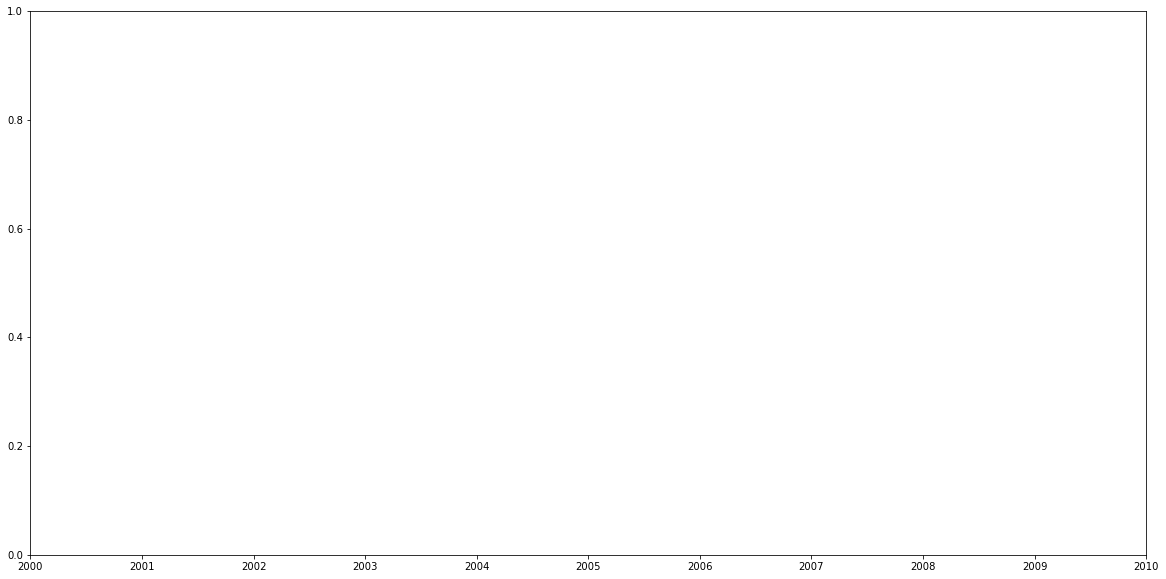

In [182]:
#plotting the original data
plot_time_patterns(df_energy.replace(np.nan,0), "Original", display_pid, False)

In [ ]:
#plotting the uninterpolated data
plot_time_patterns(df_energy_daily, "Daily", display_pid, True)

In [ ]:
#plotting the interpolated data
plot_time_patterns(df_energy_interpolate_days_interpolate.replace(np.nan,0), "Interpolated_Daily", display_pid, True)

## Resampling into different sizes for different prediction scales we will experiment with
* Going to experiment with framing this data into different time series problems and assessing which problems our model performs best at
    * E.g. predicting the next day (already processed data into days)
    * E.g. predicting the next week
    * E.g. predicting the next month
    * E.g. predicting the next year
    
* Way I am thinking of using the models is training in the days as timesteps then experimenting on testing it's ability for predicting the different time scales
    * For predicting next day and next week can probably get by on just using the data we have and splitting it into a test and train
    * For predicting next month and next year will have to submit to competition as we only have 12 months worth of data and the test set is on the comp server and inaccessible
    
* Hence for predicting smaller periods we will be able to train our RNN to make multistep predictions as we have sufficient data for that
* However, we don't have enough to predict next 12 months so will have to train it to predict a smaller amount and then iteratively use that prediction as another input to predict the next step

### Resampling the daily values into weekly values 
* Leaving commented out for now as don't want to do too much data: will just keep monthly for now

In [ ]:
#resampling non-interpolated daily data into weeks
df_energy_weekly = resample_to_different_time(df_energy_daily, "consumption_weekly","W").iloc[:, :-1] # dropping last 'week' as it's only 1 day
df_energy_weekly

In [ ]:
#resampling interpolated daily data into weeks
df_energy_weekly_interpolate = resample_to_different_time(df_energy_interpolate, "consumption_weekly_interpolated","W").iloc[:, :-1] # dropping last 'week' as it's only 1 day
df_energy_weekly_interpolate

### Resampling the daily values into monthly values

In [ ]:
#resampling non-interpolated daily data into months
df_energy_monthly= resample_to_different_time(df_energy_daily, "consumption_monthly","M")
df_energy_monthly

In [ ]:
#resampling interpolated daily data into months
df_energy_monthly_interpolate = resample_to_different_time(df_energy_interpolate, "consumption_monthly_interpolated","M")
df_energy_monthly_interpolate

## Calculating monthly averages (not sure if needed or not so commented out; may be worth using as another column after preparing data for time series?)

In [ ]:
"""#resampling into months
df_energy_month = pd.DataFrame(columns=["meter_id"])
df_energy_month["meter_id"] = meter_id

#for each month in the range of dates
for month_i in tqdm(pd.date_range(datetime(2017, 1, 1), datetime(2017, 12, 31), freq = "M")):
    #going to give column name middle of month temporarily for ease of plotting, then will remove
    middle_of_month = str(month_i.replace(day=1)+(month_i-month_i.replace(day=1))/2)
    
    #get this months name as a string
    monthName = str(month_i.date())[:7]
    #get all columns that relate to this months
    col_month_i = [i for i in df_energy_daily.columns.values[1:] if i.startswith(monthName)]
    #sum these up into a monthly value
    df_energy_month[middle_of_month] = df_energy_daily[col_month_i].mean(axis=1) # midway through month so easier to plot"""

#### Conclusions:
* Have removed the missing values that could be removed via linear interpolation:
    * when there are values before and after the sequence of ?
* Still have lots of missing values at start and end of dataset

____________________________
____________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
______________________________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
______________________________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
____________________________________________________
____________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
____________________________________
__________________________________
____________________________
__________________
__________________________________
____________________________
______________________________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
______________________________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
____________________________________________________
____________________________
__________________
__________________________________
____________________________
__________________
__________________________________
____________________________
__________________

# EDA on AddInfo
## Adding missing rows to AddInfo based on missing meter_id's

In [ ]:
# first making both dataframes alphabetical in order of meter_id for ease of comparison
df_info.sort_values('meter_id')

In [ ]:
df_energy.sort_values('meter_id')

In [ ]:
#adding the missing meter rows to df_info
df_info_all_meters = pd.merge(df_info, df_energy["meter_id"], on="meter_id",how="outer")

In [ ]:
#checking the values are correct now
df_info_all_meters.sort_values('meter_id')

In [ ]:
#checking the shape is correct now
df_info_all_meters.shape

## Exploring datatypes and unique values

In [ ]:
# inspecting the types of each column
df_info_all_meters.dtypes

In [ ]:
#looking at the unique values for each column
for column in df_info_all_meters.drop(["meter_id"],axis=1).columns:
    print(column+" unique value count: "+str(df_info_all_meters[column].nunique()))
    print(df_info_all_meters[column].unique())
    print()

* We now know:
    1. The columns that contain categorical values vs the columns that contain real numbers
    2. The unique values for each column
    
## Exploring missing values
### Visualising as histogram

In [ ]:
# plotting a histogram for each of the columns in the dataset
for column in df_info_all_meters.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_all_meters[column].replace(np.nan,"NaN").apply(str)
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/{column}_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/{column}_hist.png")
        
    plt.close(fig)

### Calculating percentage of missing values for each column

In [ ]:
# Calculating percentage of missing values
#stores index of columns to keep: defaults all to true and will check which to make false
columns = np.full((df_info_all_meters.shape[1],), True, dtype=bool)

# getting the count of each object type in each column
for i in range(0,len(df_info_all_meters.columns)):
    column =df_info_all_meters.columns[i]
    #calculating the percentage of missing values
    percent_missing = df_info_all_meters[column].isnull().sum() * 100 / len(df_info_all_meters)
    print(column+" contains missing values: "+str(df_info_all_meters[column].isna().values.any()))
    print(column+" is missing: "+str(round(percent_missing,2))+"%")
    
    #if the percentage of missing values is greater than 50% mark them to be removed
    if(percent_missing>=50):
        print("Marked ",column,"for removal due to it having more than 50% missing values")
        columns[i] = False
    else:
        print("Not marked ",column,"for removal due to it not having more than 50% missing values")
    print()

#### Meaning of findings;
* As the histograms and calculations show: there is a massive amount of missing values
* Marked all columns with > 50% missing values for removal
    * as if more than half of the values are missing it is likely what we do impute won't be accurate
* Need to decide what to do with the the remaining 2 as they have 40% missing values: is this good enough?
    * Will likely require experimentation:
        * So will run one model which only uses energy
        * And one that uses addInfo after the missing values have been imputed

## Removing the columns with greater than 50% missing values

In [ ]:
# Removing the columns marked for removal
selected_columns = df_info_all_meters.columns[columns]
df_info_all_meters = df_info_all_meters[selected_columns]

In [ ]:
# inspecting the current state of df_info_all_meters
df_info_all_meters

## Imputing the missing values
* May be worth experimenting with different imputation methods
* But for now just going with KNN

### Preparing dataframe for use by KNNImputer
### Adding information on the energy time series data that may be useful for imputing the missing addInfo values
Experimenting with different combinations 9think it may have been too many when I originally used 4 different energy ones and it got weighted too highly skewing it due to the multi collinearity problems

In [ ]:
# Calculating the total, mean, max, and min energy usage only using KNOWN values (not including the interpolated ones)
df_energy_info = pd.DataFrame(columns=["meter_id",
                                       "mean_energy_usage",
                                       #"max_energy_usage",
                                       #"min_energy_usage",
                                       "total_energy_usage"
                                      ])
df_energy_info["meter_id"]=df_energy_daily["meter_id"].values
df_energy_info["mean_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].mean(axis=1).round(3)
#df_energy_info["max_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].max(axis=1).round(3)
#df_energy_info["min_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].min(axis=1).round(3)
df_energy_info["total_energy_usage"] = df_energy_daily.replace(0,np.nan).iloc[:, 1:].sum(axis=1).round(3)

In [ ]:
df_energy_info#.loc[df_energy_means["meter_id"]=="0xa62b9f23553ff183f61e2bf943aab3d5983d02d7"]

In [ ]:
#add the total, mean, max, and min to the df for use with knn imputation
df_info_knn = df_info_all_meters
df_info_knn = df_info_knn.merge(df_energy_info[["meter_id",
                                                "mean_energy_usage",
                                                #"max_energy_usage",
                                                #"min_energy_usage", 
                                                "total_energy_usage"
                                               ]], on="meter_id",how="left")
df_info_knn#.loc[df_info_knn2["meter_id"]=="0xa62b9f23553ff183f61e2bf943aab3d5983d02d7"]

### Dropping meter_id, encoding and normalizing data so it is suitable for KNN Imputation
#### Dropping meter_id

In [ ]:
#dropping the id column so it doesn't negatively influence the knn algorithm
meter_id = df_info_knn["meter_id"]
df_info_knn = df_info_knn.drop(["meter_id"], axis=1)

In [ ]:
#inspecting the df without the id column
df_info_knn

#### Encoding the categorical values ready for knn

In [ ]:
df_info_knn_encoded = df_info_knn
df_info_knn_encoded["dwelling_type"]=df_info_knn_encoded["dwelling_type"].replace("flat",0).replace("terraced_house",1).replace("semi_detached_house",2).replace("detached_house",3).replace("bungalow",4)

"""df_dwelling_types_encoded = df_info_knn["dwelling_type"]
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("flat",0)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("terraced_house",1)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("semi_detached_house",2)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("detached_house",3)
df_dwelling_types_encoded=df_dwelling_types_encoded.replace("bungalow",4)"""

In [ ]:
df_info_knn_encoded

#### Normalizing the data

In [ ]:
# Normalizing the data as KNN is done via a distance measure and we don't want to skew it
scaler = MinMaxScaler()
df_info_knn_normalized = pd.DataFrame(scaler.fit_transform(df_info_knn_encoded), columns = df_info_knn_encoded.columns)

# inspecting new state of the dataframe after normalisation
df_info_knn_normalized

### Now data is prepared, using KNN to impute the missing values
* Experiment with different numbers for nearest neighbours

In [ ]:
# now using KNN to impute the missing values
imputer = KNNImputer(n_neighbors=5)
df_info_knn_imputed = pd.DataFrame(imputer.fit_transform(df_info_knn_normalized),columns = df_info_knn_normalized.columns)

# inspecting new state of the dataset now it no longer has missing values
df_info_knn_imputed

In [ ]:
# checking it no longer has missing values
df_info_knn_imputed.isna().any()

In [ ]:
# looking at sum of missing values
df_info_knn_imputed.isna().sum()

#### Turning these imputed values to usable values

In [ ]:
#Unnormalsing the data
df_info_knn_imputed.columns[1:] #ignoring meter id as that wasn't normalized
df_info_knn_finished = pd.DataFrame(scaler.inverse_transform(df_info_knn_imputed), columns = df_info_knn_imputed.columns) # reversing the normalization

In [ ]:
# viewing the unormalised data
df_info_knn_finished

In [ ]:
#rounding bedrooms to their final value
num_bedrooms=df_info_knn_finished["num_bedrooms"].round() 

In [ ]:
#rounding dwelling type to a real value
df_dwellings=df_info_knn_finished["dwelling_type"].round() 
#reverting the encoding
df_dwellings=df_dwellings.replace(0, "flat").replace(1, "terraced_house").replace(2, "semi_detached_house").replace(3, "detached_house").replace(4, "bungalow")


In [ ]:
#concatenating the meter_id, number of bedrooms, and dwellings columns
df_info_knn_finished = pd.concat([meter_id, num_bedrooms, df_dwellings], axis=1)

In [ ]:
#inspecting the final configuration of the knn imputed values
df_info_knn_finished

## Checking the unique values are the same as the original set

In [ ]:
#looking at the unique values for each column before imputation
print("Unique values before imputation")

print("num_bedrooms unique value count: "+str(df_info_all_meters["num_bedrooms"].nunique()))
print(df_info_all_meters["num_bedrooms"].unique())
print()
print("dwelling_type unique value count: "+str(df_info_all_meters["dwelling_type"].nunique()))
print(df_info_all_meters["dwelling_type"].unique())
print()

In [ ]:
#looking at the unique values for each column before imputation
print("Unique values after imputation\n")

print("num_bedrooms unique value count: "+str(df_info_knn_finished["num_bedrooms"].nunique()))
print(df_info_knn_finished["num_bedrooms"].unique())
print()
print("dwelling_type unique value count: "+str(df_info_knn_finished["dwelling_type"].nunique()))
print(df_info_knn_finished["dwelling_type"].unique())
print()

## Comparing the distribution of unique values that were distributed to the original

In [ ]:
#looking at percentage distribution of values before imputation
print("Distribution of unique values before imputation")
print()

num_bedrooms_percentages = df_info_all_meters['num_bedrooms'].value_counts(normalize=True) * 100
print("num_bedrooms percentages")
print(num_bedrooms_percentages)
print()
print("num_bedrooms totals")
print(df_info_all_meters['num_bedrooms'].value_counts())
print()
print()

dwelling_type_percentages = df_info_all_meters['dwelling_type'].value_counts(normalize=True) * 100
print("dwelling_type percentages")
print(dwelling_type_percentages)
print()
print("dwelling_type totals")
print(df_info_all_meters['dwelling_type'].value_counts())

In [ ]:
#looking at percentage distribution of values after imputation
print("Distribution of unique values before imputation")
print()

num_bedrooms_percentages = df_info_knn_finished['num_bedrooms'].value_counts(normalize=True) * 100
print("num_bedrooms percentages")
print(num_bedrooms_percentages)
print()
print("num_bedrooms totals")
print(df_info_knn_finished['num_bedrooms'].value_counts())
print()
print()

dwelling_type_percentages = df_info_knn_finished['dwelling_type'].value_counts(normalize=True) * 100
print("dwelling_type percentages")
print(dwelling_type_percentages)
print()
print("dwelling_type totals")
print(df_info_knn_finished['dwelling_type'].value_counts())
print()

##### Conclusions:
* Hasn't imputed any meters to be a flat
* Hasn't imputed any meters to have 1 or 5 bedrooms
* Has essentially increased the % divide
    * Higher % represented classes were more likely to be picked
    * Whilst lower % represented classes were less likely to be picked 
* Expected behaviour but is this useful and has it imputed correctly?
* As mentioned already will experiment and see if using these meters or not improves performance more
    * From this we can infer if this was effective or not

## Plotting hists of the imputed addInfo
plotting hists of the imputed addInfo columns before and after imputation to compare their patterns

In [ ]:
# plotting a histogram for each of the imputed columns in the dataset before imputation
for column in df_info_knn_finished.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_all_meters[column]
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/Pre-Imputation/{column}_preimp_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/Pre-Imputation/{column}_preimp_hist.png")
        
    plt.close(fig)

In [ ]:
# plotting a histogram for each of the columns in the dataset after imputation
for column in df_info_knn_finished.drop(["meter_id"],axis=1).columns:
    df_temp = df_info_knn_finished[column]
    ax = df_temp.hist(figsize=(10,10))
    ax.set_xlabel("unique values")
    ax.set_ylabel("count")
    fig = ax.get_figure()
    plt.title(column+" values")
    plt.show(block=False)
    
    if(os.path.exists(f"../EDA/plots/addInfo/Imputed/{column}_imp_hist.png")==False):
        fig.savefig(f"../EDA/plots/addInfo/Imputed/{column}_imp_hist.png")
        
    plt.close(fig)

## OneHot Encoding Ready for the RNN to make use of

In [ ]:
#encoding the categorical values via one hot encoding
cat_variables = df_info_knn_finished[df_info_knn_finished.loc[:,df_info_knn_finished.columns!="meter_id"].select_dtypes(include=['object']).columns] # getting the categorical columns (just 'dwelling_type')
cat_dummies = pd.get_dummies(cat_variables, drop_first=True, dummy_na=True) # getting dummies, including a separate one for na

#setting nan rows and droppoing nan column
cat_dummies.loc[cat_dummies.dwelling_type_nan==1, ["dwelling_type_detached_house","dwelling_type_flat","dwelling_type_semi_detached_house","dwelling_type_terraced_house"]]=np.nan
cat_dummies=cat_dummies.drop("dwelling_type_nan",axis=1)
cat_dummies

In [ ]:
# dropping those original columns then adding the dummy values
df_info_knn_finished = df_info_knn_finished.drop(df_info_knn_finished.loc[:,df_info_knn_finished.columns!="meter_id"].select_dtypes(include=['object']).columns, axis=1)
df_info_knn_finished = pd.concat([df_info_knn_finished, cat_dummies], axis=1)
# inspecting new state of the dataframe with the dummy variables
df_info_knn_finished

## Generating correlation plot of the features to make sure there is minimal redundancy

In [ ]:
#generating the correlation matrix
corr_info = df_info_knn_finished.corr()

In [ ]:
#generating the correlation heat map
plt.figure(figsize=(10, 10))
sns.heatmap(corr_info, cmap="coolwarm", annot=True, square=True)

In [ ]:
# for each feature on the x axis
for i in range(corr_info.shape[0]):
    # for each feature after i
    for j in range(i+1, corr_info.shape[0]):
        #check if their correlation is above a threshold % (50%)
        if abs(corr_info.iloc[i,j]) >= 0.5:
            print("\nConsider ",corr_info.columns[j]," for removal as it has a high correlation with ",corr_info.columns[i]," of",round(corr_info.iloc[i,j],2),"\n")
            #set column j to be removed 
            if columns[j]:
                columns[j+1] = False #+1 for meter id
        else: 
            print("Keeping ",corr_info.columns[i]," and ",corr_info.columns[j]," have a correlation of ", round(corr_info.iloc[i,j],2))

##### Features don't have a particularly high correlation; no need to remove them based upon this

## Saving the finished AddInfo

In [ ]:
if(os.path.exists(f"../Data/Preprocessed_Data/addInfo_knn.pkl")==False):
        df_info_knn_finished.to_pickle(f"../Data/Preprocessed_Data/addInfo_knn.pkl")